In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import os

In [13]:
def load_map(path):

    map_image = cv2.imread(path, cv2.IMREAD_COLOR)
    map_image=cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
    _, map_data = cv2.threshold(cv2.cvtColor(map_image, cv2.COLOR_RGB2GRAY), 127, 1, cv2.THRESH_BINARY)
    
    return map_data


In [14]:
def show_image(image,title,is_gray):
    plt.figure(figsize=(6, 6))
    if is_gray:
        plt.gray()
        plt.imshow(image)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    plt.title(title)
    plt.show()

# Problem 1

In [15]:
def draw_robot(map_data,pose):
    x,y,theta = pose
    cv2.circle(map_data, (x, y), 7, (0, 0, 255), thickness=-1)

    orientation_length = 15  
    end_orientation_x = int(x + orientation_length * np.cos(np.radians(theta)))
    end_orientation_y = int(y + orientation_length * np.sin(np.radians(theta)))
    cv2.line(map_data, (x, y), (end_orientation_x, end_orientation_y), (0, 0, 0), 1)
    
    return map_data

In [16]:
def cast_rays(map_data,pose, angle_step=2, max_range=1200,resolution=4,opening_angle=250):

    x_pixels, y_pixels, theta = pose
    map_data_copy = map_data.copy()
    map_data_copy = cv2.cvtColor(map_data_copy * 255, cv2.COLOR_GRAY2BGR)

    start_angle = theta - (opening_angle/2)
    end_angle = theta + (opening_angle/2)
    angles = np.arange(start_angle, end_angle+1, angle_step)
    measurements = []

    for angle in angles:

        end_x_pixels = int( x_pixels + (max_range / resolution) * np.cos(np.radians(angle)))
        end_y_pixels = int( y_pixels + (max_range / resolution) * np.sin(np.radians(angle)))



        rr, cc = sk.draw.line(x_pixels, y_pixels, end_x_pixels, end_y_pixels)

        valid_points_x = []
        valid_points_y = []
        for r, c in zip(rr, cc):
            if 0 <= r < map_data.shape[1] and 0 <= c < map_data.shape[0]:
                valid_points_x.append(r)
                valid_points_y.append(c)
            else:
                break 

        valid_points_x = np.array(valid_points_x)
        valid_points_y = np.array(valid_points_y)

        obstacle_indices = np.where(map_data[valid_points_y, valid_points_x] == 0)[0]
        if len(obstacle_indices) == 0:
            distance = max_range / resolution
            cv2.line(map_data_copy, (x_pixels, y_pixels), (end_x_pixels,end_y_pixels), (0,255,0), 1)
        else:
            obstacle_x = valid_points_x[obstacle_indices[0]]
            obstacle_y = valid_points_y[obstacle_indices[0]]
            distance = np.sqrt((obstacle_x - x_pixels)**2 + (obstacle_y - y_pixels)**2)
            cv2.line(map_data_copy, (x_pixels, y_pixels), (obstacle_x,obstacle_y), (0,255,0), 1)


        measurements.append(distance)

    map_data_copy = draw_robot(map_data_copy,pose)

    show_image(map_data_copy,f"Position: {x_pixels,y_pixels} orientation: {theta}", is_gray=False)

    output_dir = "outputs/P1"
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"Position({x_pixels}_{y_pixels})_orientation_{theta}.png")
    cv2.imwrite(output_path, map_data_copy)
    return measurements


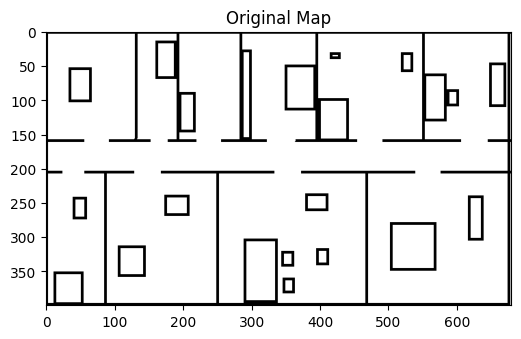

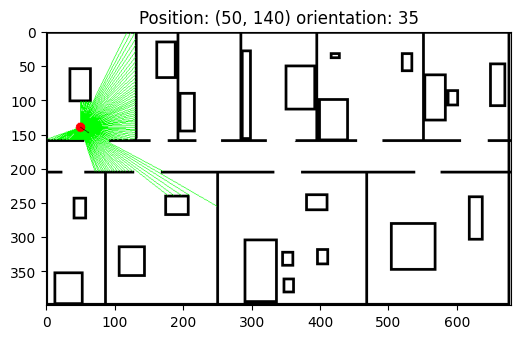

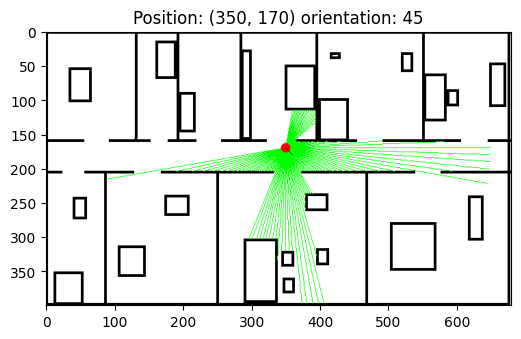

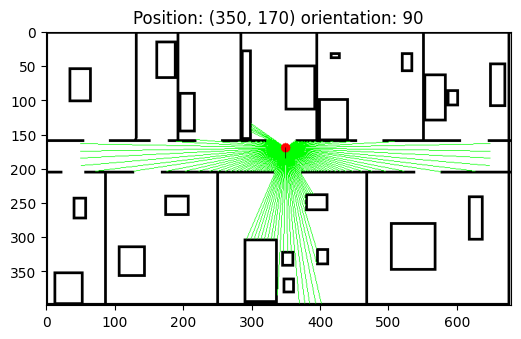

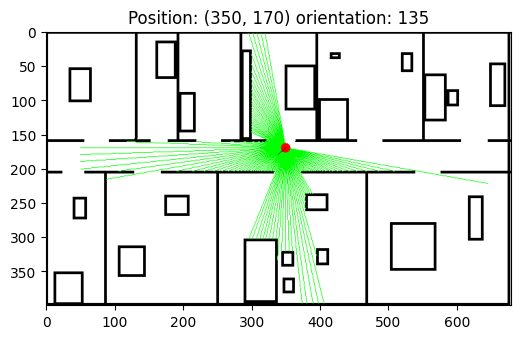

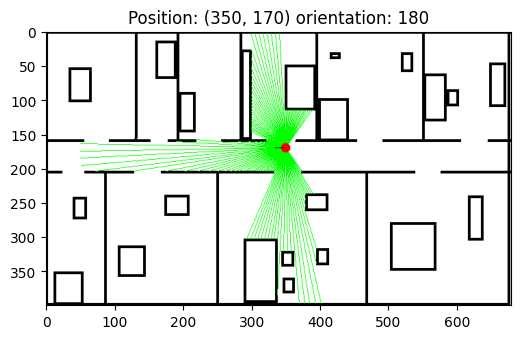

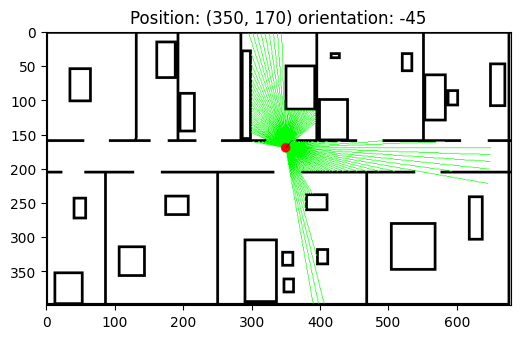

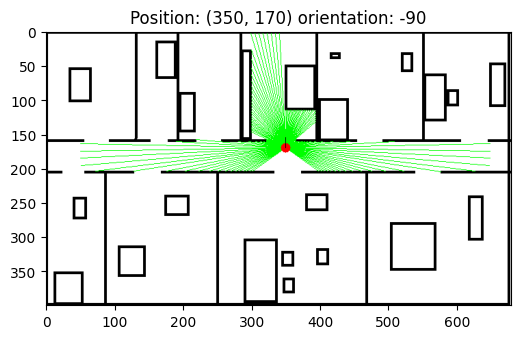

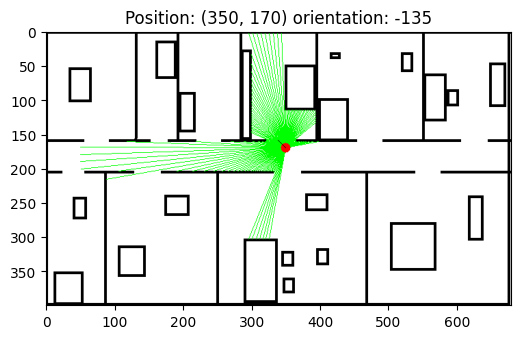

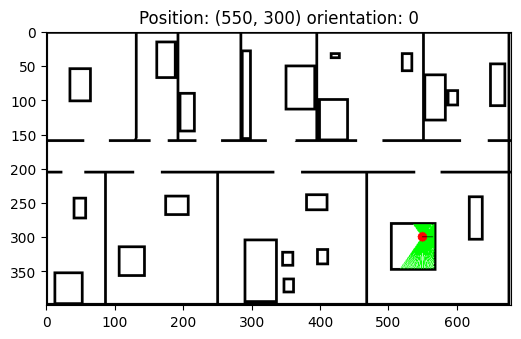

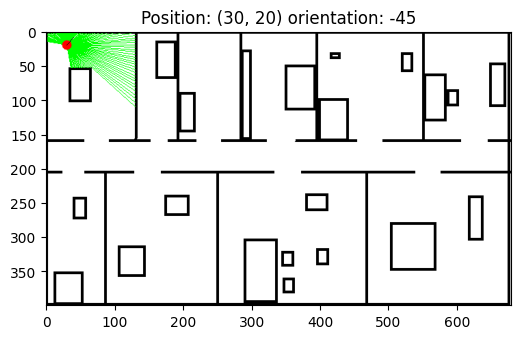

[np.float64(28.442925306655784),
 np.float64(28.635642126552707),
 np.float64(28.861739379323623),
 np.float64(29.120439557122072),
 np.float64(29.410882339705484),
 np.float64(29.732137494637012),
 np.float64(30.083217912982647),
 np.float64(30.463092423455635),
 np.float64(31.304951684997057),
 np.float64(31.76476034853718),
 np.float64(32.2490309931942),
 np.float64(31.906112267087632),
 np.float64(30.23243291566195),
 np.float64(28.600699292150182),
 np.float64(27.80287754891569),
 np.float64(26.248809496813376),
 np.float64(25.495097567963924),
 np.float64(24.758836806279895),
 np.float64(23.345235059857504),
 np.float64(22.67156809750927),
 np.float64(22.02271554554524),
 np.float64(21.400934559032695),
 np.float64(20.808652046684813),
 np.float64(20.248456731316587),
 np.float64(20.248456731316587),
 np.float64(19.72308292331602),
 np.float64(19.235384061671343),
 np.float64(18.788294228055936),
 np.float64(18.788294228055936),
 np.float64(18.384776310850235),
 np.float64(18.027

In [17]:
map_data = load_map("Map.jpg")

show_image(map_data, "Original Map", is_gray=True)

cast_rays(map_data, (50, 140, 35))
cast_rays(map_data, (350, 170, 45))
cast_rays(map_data, (350, 170, 90))
cast_rays(map_data, (350, 170, 135))
cast_rays(map_data, (350, 170, 180))
cast_rays(map_data, (350, 170, -45))
cast_rays(map_data, (350, 170, -90))
cast_rays(map_data, (350, 170, -135))

cast_rays(map_data, (550, 300, 0))
cast_rays(map_data, (30, 20, -45))

# Problem 2

In [18]:
def preprocessing(map_data):
    map_data = map_data + 0.01 
    map_data = cv2.bitwise_not(map_data)
    map_data = cv2.GaussianBlur(map_data, (7,7), 0)
    map_data /= np.max(map_data) 
    return map_data


In [19]:
def endpoint(map_data,measurements, angle_step=2, max_range=1200,resolution=4,opening_angle=250):

    map_data = preprocessing(map_data)

    rows, cols = map_data.shape
    likelihood_map = np.zeros_like(map_data, dtype=float)
    max_likelihood = 0.0
    max_ind_x = 0
    max_ind_y = 0
    max_orientation = 0

    for x in range(0,cols,5):
        for y in range(0,rows,5):
            for orientation in range(0,360,5):
                likelihood = 1.0
                start_angle =  orientation - (opening_angle/2)
                end_angle =  orientation + (opening_angle/2)

                angles = np.arange(start_angle, end_angle + 1, angle_step)

                for i,angle in enumerate(angles):

                    end_x = int(x + measurements[i] * np.cos(np.radians(angle)))
                    end_y = int(y + measurements[i] * np.sin(np.radians(angle)))

                    if 0 <= end_x < cols and 0 <= end_y < rows:
                        likelihood *= (map_data[end_y][end_x])
                    else:
                        likelihood *= 0.00001
                        
                if likelihood > max_likelihood:
                    max_likelihood = likelihood
                    max_ind_x,max_ind_y=x,y
                    max_orientation = orientation

                
            likelihood_map[y, x] = max_likelihood

    result = np.zeros_like(likelihood_map)
    result[max_ind_y][max_ind_x]=1
    
    print("Result is",max_ind_x,max_ind_y,max_orientation)

    kernel = np.ones((9, 9), np.uint8)
    dilated_result = cv2.dilate(result.astype(np.uint8), kernel, iterations=1)
    
    show_image(dilated_result,"likelihood map",is_gray=True)

    output_dir = "outputs/P2"
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"Result position({max_ind_x}_{max_ind_y}_orientation_{max_orientation}).png")
    dilated_result = dilated_result * 255
    cv2.imwrite(output_path, dilated_result)

    dilated_result = dilated_result / 255

    return dilated_result

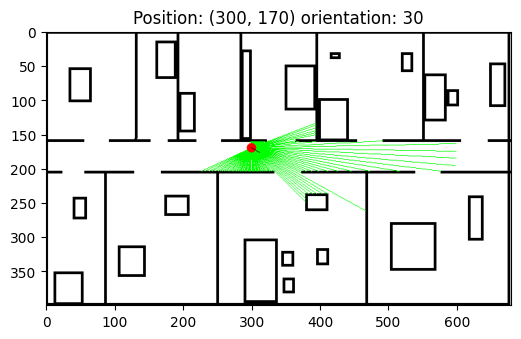

Result is 300 170 30


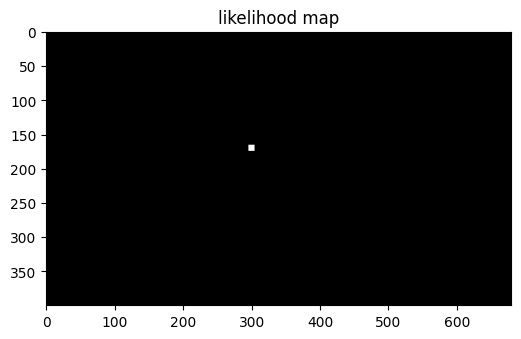

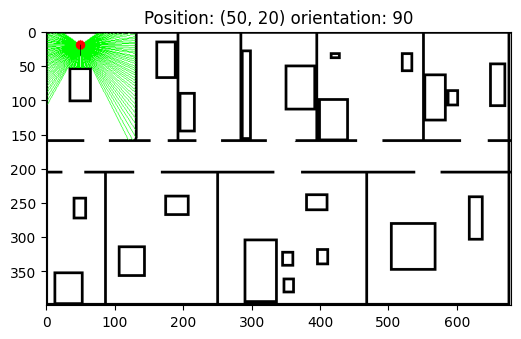

Result is 50 20 90


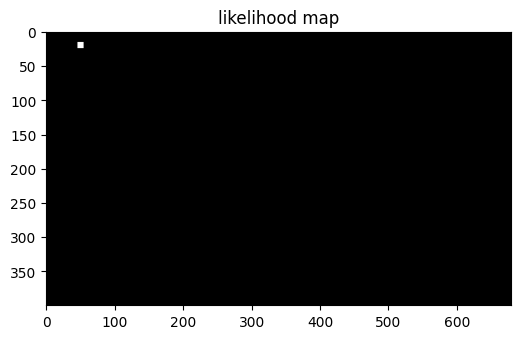

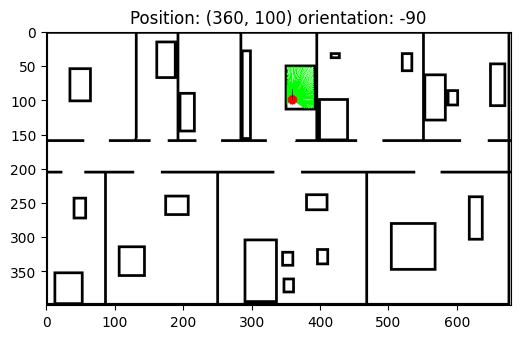

Result is 360 100 270


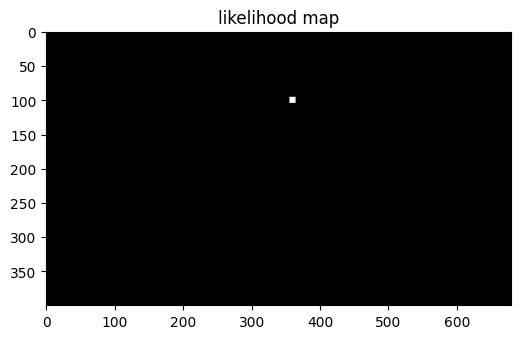

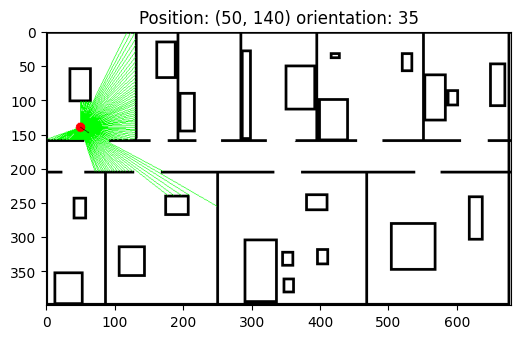

Result is 50 140 35


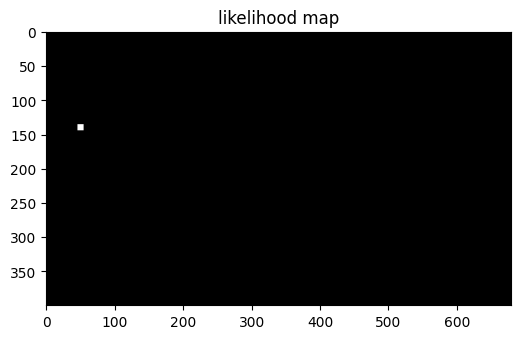

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
map_data = load_map("Map.jpg")

measurements = cast_rays(map_data,(300, 170, 30))
endpoint(map_data,measurements)

measurements = cast_rays(map_data,(50, 20, 90))
endpoint(map_data,measurements)

measurements = cast_rays(map_data,(360, 100, -90))
endpoint(map_data,measurements)

measurements = cast_rays(map_data,(50, 140, 35))
endpoint(map_data,measurements)
